In [1]:
import os
import sys
import PyQt5
import numpy as np
import cv2
from mayavi import mlab
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from sklearn.decomposition import PCA
import tifffile

In [2]:
# Define Metadata for the data file 
# You should be able to get this info in ImageJ from Image > Properties
X_SCALE = 3791586e-7       # pixel width
Y_SCALE = 3791586e-7       # pixel height
Z_SCALE = 10045202e-7       # voxel depth

# Additional parameters: 
Z_REF = 0 
VALUE_THRESHOLD = 0.10     # to remove background (needs fine-tuning per cell)

In [3]:
def open_tif(file_path):
    """
    Given a tif file path, it stores the z-stack in the array 'image' and 
    reads its dimensions.  
    """
  
    image        = tifffile.imread(file_path)
    num_slices   = image.shape[0]  
    num_channels = image.shape[1]  
    x_dim        = image.shape[2]  
    y_dim        = image.shape[3]  
    
   
    data_shape = [num_slices, num_channels, x_dim, y_dim]
    
    return image, data_shape

def preprocess_image(slice, channel_mult, VALUE_THRESHOLD):
    """
    Each image has 3 channels and at each channel we have images of different protein structures of the cells.
    What we would like to do is to normalize each channel first then threshold in HSV space to determine where we 
    denote the strctural elements for didinium locations. 

    Inputs : 
        slice_input : current slice we are considering, an image
        channel_mult : an array with 3 values. 
        example use if channel_mult = [1, 1, 1] each channel is multiplied with 1.0 before thresholding operations
                    if channel_mult = [0, 0, 1] you are only taking the structure in the last channel 
                    if channel_mult = [0, 0, 5] maybe you are not getting enough data points to represent the channel
                    structure so you'd want to multiply the channel with a higher value so that more datapoints are above
                    the threshold for 3D representation of the channel. 
        VALUE_THRESHOLD : threshold for putting a point in location, should be between 0 and 1
                          if VALUE_THRESHOLD is high you'll have a more dense point cloud and vice versa
    """

    assert len(channel_mult) == 3, "channel_mult should be an array with 3 inputs."
    assert 0.0 < VALUE_THRESHOLD and VALUE_THRESHOLD < 1.0, "VALUE_THRESHOLD should be between 0 and 1"
    
    
    # Find the minimum and maximum values in the array
    min_value = slice.min()
    max_value = slice.max()
    
    # Normalize the array to the range [0, 1]
    slice = (slice - min_value) / (max_value - min_value)
    
    # Convert the 3D array to an image
    image = np.moveaxis(slice, 0, -1)

    # Multiply channel values to eliminate some channels if preferred
    image[ :, :, 0] = image[ :, :, 0] * channel_mult[0]
    image[ :, :, 1] = image[ :, :, 1] * channel_mult[1]
    image[ :, :, 2] = image[ :, :, 2] * channel_mult[2]
    
    # Convert RGB to HSV and extract the value (V) channel
    hsv_image = colors.rgb_to_hsv(image)
    
    value_channel = hsv_image[:,:, 2]
    
    value_channel_thresh = np.copy(value_channel)
    
    # This thresholding needs some fine tuning 
    value_channel_thresh[value_channel < VALUE_THRESHOLD] = 0.0
    value_channel_thresh[value_channel_thresh > 0.0] = 1.0
    
    return value_channel_thresh


def generate_point_cloud(channels, shape, X_SCALE, Y_SCALE, Z_SCALE, 
                         channel_mult=[1, 1, 1], n = 3, VALUE_THRESHOLD=0.33) -> np.ndarray:
    """
    Generate point cloud from zstack 

    Inputs : 
        channels : zstack of all channels in RGB
        shape : computed from zstack
        X_SCALE, Y_SCALE, Z_SCALE : metadata
        channel_mult : an array with 3 values. 
        example use if channel_mult = [1, 1, 1] each channel is multiplied with 1.0 before thresholding operations
                    if channel_mult = [0, 0, 1] you are only taking the structure in the last channel 
                    if channel_mult = [0, 0, 5] maybe you are not getting enough data points to represent the channel
                    structure so you'd want to multiply the channel with a higher value so that more datapoints are above
                    the threshold for 3D representation of the channel. 
        VALUE_THRESHOLD : threshold for putting a point in location, should be between 0 and 1
                          if VALUE_THRESHOLD is high you'll have a more dense point cloud and vice versa
    Returns:
        array of point cloud locations xyz as numpy array
    """
    point_cloud = []
    for z in range(shape[0]-n):
        curr_img = channels[z,:,:,:]
        processed_img = preprocess_image(curr_img, channel_mult=channel_mult, VALUE_THRESHOLD=VALUE_THRESHOLD)
       
        for i in range(processed_img.shape[0]):
            for j in range(processed_img.shape[1]):
                if processed_img[i,j] != 0.0:
                    loc = pixel_to_xyz(X=i, Y=j, Z=z, X_SCALE=X_SCALE, Y_SCALE=Y_SCALE, Z_SCALE=Z_SCALE)
                    point_cloud.append(loc)

    print("Point Cloud is Generated!")

    return np.transpose(point_cloud) # transpose works the best



def pixel_to_xyz(X, Y, Z, X_SCALE, Y_SCALE, Z_SCALE):
    """
    Calculate xyz location based on image scale and location on image
    X_SCALE, Y_SCALE, Z_SCALE : metadata
    """
    return np.array([X*X_SCALE, Y*Y_SCALE, Z*Z_SCALE])


def visualize_pointcloud(data, title = None, fig_id = 1):
    # For visualizing point clouds
    x = data[0,:] 
    y = data[1,:] 
    z = data[2,:] 

    if title is None:
        title = "Point Cloud"

    # Visualize it with mlab.surf
    col = z
    fig = mlab.figure(fig_id, bgcolor=(0, 0, 0), size=(128*5,128*5))
    mlab.points3d(x, 
                  y, 
                  z,
                  col,
                  mode="point",
                  colormap='spectral',
                  figure=fig,
                  )
    mlab.title(title, height=0.1, size=0.4)

In [4]:
# ############################ Code to mask the corners in each of the stacks - Takes so much time but gives better results ##############################
# def open_tif(file_path):
#     """
#     Given a tif file path, it stores the z-stack in the array 'image' and 
#     reads its dimensions.
#     """
#     image = tifffile.imread(file_path)
#     num_slices = image.shape[0]
#     num_channels = image.shape[1]
#     x_dim = image.shape[2]
#     y_dim = image.shape[3]

#     data_shape = [num_slices, num_channels, x_dim, y_dim]
#     return image, data_shape

# def create_corner_mask(image_shape, radius_ratio=0.25):
#     """
#     Create a mask that removes the corners of an image with a larger radius to cover more of the edges.
    
#     Inputs:
#         image_shape : shape of the image to be masked (x_dim, y_dim)
#         radius_ratio : ratio of the smallest dimension to be masked from the corners
        
#     Returns:
#         mask : binary mask with the same shape as the input image slice
#     """
#     x_dim, y_dim = image_shape
#     mask = np.ones((x_dim, y_dim))
    
#     # Define the radius as a ratio of the smallest image dimension
#     radius = int(min(x_dim, y_dim) * radius_ratio)
    
#     # Create circular masks for each corner (zero out the corners)
#     for i in [0, x_dim - 1]:
#         for j in [0, y_dim - 1]:
#             for x in range(x_dim):
#                 for y in range(y_dim):
#                     if np.sqrt((x - i)**2 + (y - j)**2) < radius:
#                         mask[x, y] = 0
    
#     # print(f"Mask created with radius {radius}, applied to image of shape {x_dim}x{y_dim}")
#     return mask

# def preprocess_image(slice, channel_mult, VALUE_THRESHOLD, apply_mask=True, radius_ratio=0.25):
#     """
#     Preprocess the image by normalizing channels and applying a mask to the edges.
    
#     Inputs:
#         slice : 3D input slice with 3 channels
#         channel_mult : array to control the contribution of each channel
#         VALUE_THRESHOLD : threshold value for channel data (0 < VALUE_THRESHOLD < 1)
#         apply_mask : flag to apply the corner mask, default True
#         radius_ratio : ratio of the smallest image dimension to remove from the corners
        
#     Returns:
#         value_channel_thresh : binary thresholded array after normalization and masking
#     """
#     assert len(channel_mult) == 3, "channel_mult should be an array with 3 inputs."
#     assert 0.0 < VALUE_THRESHOLD < 1.0, "VALUE_THRESHOLD should be between 0 and 1"

#     # Normalize the slice
#     min_value = slice.min()
#     max_value = slice.max()
#     slice = (slice - min_value) / (max_value - min_value)
    
#     # Convert the 3D array to an image
#     image = np.moveaxis(slice, 0, -1)  # move channels to last dimension (height, width, channels)

#     # Multiply channel values based on channel_mult
#     image[:, :, 0] *= channel_mult[0]
#     image[:, :, 1] *= channel_mult[1]
#     image[:, :, 2] *= channel_mult[2]
    
#     # Optionally apply the mask to the image
#     if apply_mask:
#         mask = create_corner_mask(image.shape[:2], radius_ratio=radius_ratio)
#         image[:, :, 0] *= mask
#         image[:, :, 1] *= mask
#         image[:, :, 2] *= mask
#         # print(f"Mask applied with radius_ratio {radius_ratio}")
    
#     # Convert RGB to HSV using matplotlib.colors
#     hsv_image = colors.rgb_to_hsv(image)
#     value_channel = hsv_image[:, :, 2]
    
#     # Threshold the value channel
#     value_channel_thresh = np.copy(value_channel)
#     value_channel_thresh[value_channel < VALUE_THRESHOLD] = 0.0
#     value_channel_thresh[value_channel >= VALUE_THRESHOLD] = 1.0
    
#     return value_channel_thresh

# def generate_point_cloud(channels, shape, X_SCALE, Y_SCALE, Z_SCALE, 
#                          channel_mult=[1, 1, 1], n=3, VALUE_THRESHOLD=0.33, radius_ratio=0.25) -> np.ndarray:
#     """
#     Generate point cloud from z-stack with masking applied to remove noisy data at the edges.
    
#     Inputs: 
#         channels : z-stack of all channels in RGB
#         shape : computed from z-stack
#         X_SCALE, Y_SCALE, Z_SCALE : metadata for scaling
#         channel_mult : array to control the contribution of each channel
#         VALUE_THRESHOLD : threshold value for channel data (0 < VALUE_THRESHOLD < 1)
#         radius_ratio : ratio of the smallest dimension to be masked from the corners
    
#     Returns:
#         array of point cloud locations (xyz) as numpy array
#     """
#     point_cloud = []
#     for z in range(shape[0] - n):
#         curr_img = channels[z, :, :, :]
#         processed_img = preprocess_image(curr_img, channel_mult=channel_mult, VALUE_THRESHOLD=VALUE_THRESHOLD, radius_ratio=radius_ratio)
       
#         for i in range(processed_img.shape[0]):
#             for j in range(processed_img.shape[1]):
#                 if processed_img[i, j] != 0.0:
#                     loc = pixel_to_xyz(X=i, Y=j, Z=z, X_SCALE=X_SCALE, Y_SCALE=Y_SCALE, Z_SCALE=Z_SCALE)
#                     point_cloud.append(loc)

#     print("Point Cloud is Generated!")
#     return np.transpose(point_cloud)  # transpose for correct ordering

# def pixel_to_xyz(X, Y, Z, X_SCALE, Y_SCALE, Z_SCALE):
#     """
#     Calculate xyz location based on image scale and location on image.
#     """
#     return np.array([X * X_SCALE, Y * Y_SCALE, Z * Z_SCALE])

# def visualize_pointcloud(data, title=None, fig_id=1):
#     # For visualizing point clouds
#     x = data[0, :]
#     y = data[1, :]
#     z = data[2, :]

#     if title is None:
#         title = "Point Cloud"

#     # Visualize with mlab.points3d
#     fig = mlab.figure(fig_id, bgcolor=(0, 0, 0), size=(640, 640))
#     mlab.points3d(x, y, z, z, mode="point", colormap='spectral', figure=fig)
#     mlab.title(title, height=0.1, size=0.4)
#     mlab.show()

In [5]:
raw_data_file = "C:\\Users\\Sama Wael\\OneDrive\\Desktop\\Epfl\\LPL Internship\\Summer projects 2024\\Didinium\\20240705-dapi_asc_tub_poly_e_20_june_sample.lif - Image 2.tif"

In [6]:
channels_input, channels_input_shape = open_tif(raw_data_file)

# The image I shared has two channels corresponding to staining of different proteins. However, the code always 
# expects 3 channels!  To avoid errors from the function preprocess_image I am creating a fake empty channel with zeros 
# that will be thresholded and removed anyway by selecting channel_mult = [#, #, 0] in the generate_point_cloud function. 

# Create a fake channel to match expected dimensions
fake_channel = np.zeros_like(channels_input[:,0:1,:,:])

# Concatenate to the real input 
channels = np.concatenate((channels_input, fake_channel), axis=1)
channels_shape = channels.shape

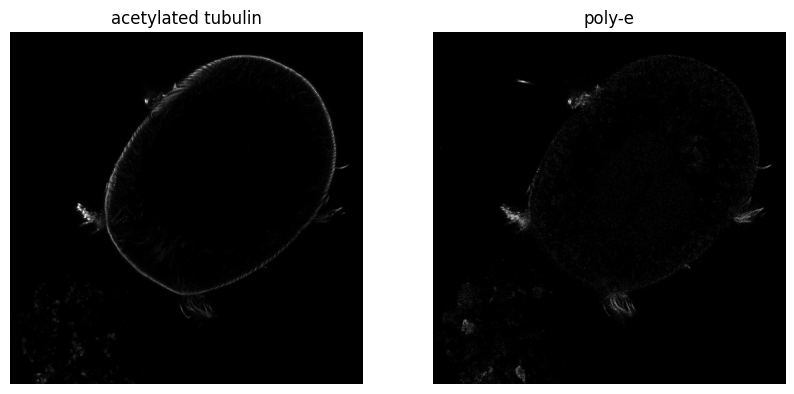

In [7]:
# Visualization of a given slice
slice_number = 50

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('acetylated tubulin')
plt.imshow(channels[slice_number,0,:,:], cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('poly-e')
plt.imshow(channels[slice_number,1,:,:], cmap='gray')
plt.axis('off')
plt.show()

In [8]:
# now construct the whole structure
point_cloud_test_both = generate_point_cloud(channels, channels_shape, X_SCALE, Y_SCALE, Z_SCALE, channel_mult=[5, 5, 0], n = 3, VALUE_THRESHOLD=0.33)                                     

# just the first channel
point_cloud_test_1 = generate_point_cloud(channels, channels_shape, X_SCALE, Y_SCALE, Z_SCALE, channel_mult=[5, 0, 0], n = 3, VALUE_THRESHOLD=0.33)                                     

# just the second channel 
point_cloud_test_2 = generate_point_cloud(channels, channels_shape, X_SCALE, Y_SCALE, Z_SCALE, channel_mult=[0, 5, 0], n = 3, VALUE_THRESHOLD=0.33)                                     


Point Cloud is Generated!
Point Cloud is Generated!
Point Cloud is Generated!


In [9]:
%gui qt
# visualize the whole structure
visualize_pointcloud(data=point_cloud_test_both, fig_id=1)
# visualize the first channel
visualize_pointcloud(data=point_cloud_test_1, fig_id=2)
# # visualize the second channel 
visualize_pointcloud(data=point_cloud_test_2, fig_id=3)

In [10]:
def compute_max_spread_point(point_cloud):
    # Compute the mean point
    mean_point = np.mean(point_cloud, axis=1)
    # Compute the distances from the mean
    diffs = point_cloud - mean_point[:, np.newaxis]
    dists = np.linalg.norm(diffs, axis=0)
    # Find the index of the maximum distance
    max_spread_index = np.argmax(dists)
    return point_cloud[:, max_spread_index]

def project_point_onto_plane(point, normal, point_on_plane):
    point_to_plane = point - point_on_plane
    distance = np.dot(point_to_plane, normal)
    projected_point = point - distance * normal
    return projected_point

def project_points_onto_plane(point_cloud, normal, point_on_plane):
    # Project each point onto the plane
    projected_points = np.apply_along_axis(project_point_onto_plane, 1, point_cloud.T, normal, point_on_plane)
    return projected_points.T  # Transpose back to (3, N)

def visualize_pointcloud_with_axis_and_plane(point_cloud, axis, mean, plane_point, title=None, fig_id=1):
    x = point_cloud[0, :] 
    y = point_cloud[1, :] 
    z = point_cloud[2, :] 

    if title is None:
        title = "Point Cloud with Axis of Symmetry and Plane"

    col = z
    fig = mlab.figure(fig_id, bgcolor=(0, 0, 0), size=(800, 800))
    mlab.points3d(x, y, z, col, mode="point", colormap='spectral', figure=fig)
    
    # Plot the axis of symmetry
    mlab.plot3d([mean[0] - 50 * axis[0], mean[0] + 50 * axis[0]],
                [mean[1] - 50 * axis[1], mean[1] + 50 * axis[1]],
                [mean[2] - 50 * axis[2], mean[2] + 50 * axis[2]],
                tube_radius=1, color=(1, 1, 1))
    
    # Plot the balanced plane
    normal = np.cross(axis, plane_point - mean)
    normal /= np.linalg.norm(normal)
    d = -np.dot(normal, mean)
    xx, yy = np.meshgrid(np.linspace(mean[0] - 50, mean[0] + 50, 10), 
                         np.linspace(mean[1] - 50, mean[1] + 50, 10))
    zz = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]
    
    mlab.mesh(xx, yy, zz, opacity=0.5, color=(0, 1, 0))
    
    mlab.title(title, height=0.1, size=0.4)
    mlab.show()

def visualize_projected_points(projected_points, title=None, fig_id=2):
    x = projected_points[0, :] 
    y = projected_points[1, :] 
    z = projected_points[2, :] 

    if title is None:
        title = "Projected Points on the Plane"

    col = z
    fig = mlab.figure(fig_id, bgcolor=(0, 0, 0), size=(800, 800))
    mlab.points3d(x, y, z, col, mode="point", colormap='spectral', figure=fig)
    
    mlab.title(title, height=0.1, size=0.4)
    mlab.show()

def find_balanced_plane(point_cloud, axis, mean_point):
    def compute_plane_params(normal, point):
        d = -np.dot(normal, point)
        distances = np.dot(point_cloud.T, normal) + d
        return np.abs(distances)

    initial_plane_point = compute_max_spread_point(point_cloud)
    initial_plane_normal = np.cross(axis, initial_plane_point - mean_point)
    initial_plane_normal /= np.linalg.norm(initial_plane_normal)
    
    best_plane_point = mean_point
    min_deviation = np.inf
    for i in range(10):
        offset = (np.random.rand(3) - 0.5) * 10
        trial_plane_point = mean_point + offset
        normal = np.cross(axis, trial_plane_point - mean_point)
        normal /= np.linalg.norm(normal)
        distances = compute_plane_params(normal, trial_plane_point)
        deviation = np.std(distances)
        if deviation < min_deviation:
            min_deviation = deviation
            best_plane_point = trial_plane_point

    best_plane_normal = np.cross(axis, best_plane_point - mean_point)
    best_plane_normal /= np.linalg.norm(best_plane_normal)

    return best_plane_point, best_plane_normal

# Performing PCA
pca = PCA(n_components=3)
pca.fit(point_cloud_test_1.T)
refined_axis_of_symmetry = pca.components_[0]
mean_point = np.mean(point_cloud_test_1, axis=1)

# Balancing of Generated Plane and Visualization
balanced_plane_point, balanced_plane_normal = find_balanced_plane(point_cloud_test_1, refined_axis_of_symmetry, mean_point)
projected_points_1 = project_points_onto_plane(point_cloud_test_1, balanced_plane_normal, balanced_plane_point)
visualize_pointcloud_with_axis_and_plane(point_cloud_test_1, refined_axis_of_symmetry, mean_point, balanced_plane_point)

# Visualization of the projected points separately
visualize_projected_points(projected_points_1)

In [11]:
## Needs some adjustments of the threshold to make sure that it works best
def pointcloud_to_grayscale(x, y, z=None, image_size=(512, 512), min_contour_area=2000, min_major_axis=50, threshold_value=80, x_scale=3249932e-7, y_scale=3249932e-7):
    def compute_real_length(major_axis_length, minor_axis_length, x_scale, y_scale):
        
        # Convert pixel lengths to real-world lengths directly
        major_axis_real_length = major_axis_length * x_scale
        minor_axis_real_length = minor_axis_length * y_scale
        
        return major_axis_real_length, minor_axis_real_length

    # Create the grayscale image
    hist, xedges, yedges = np.histogram2d(x, y, bins=image_size, weights=z)
    hist /= np.max(hist)

    # Pre-processing of the image for the contours detection
    hist_normalized = (hist * 255).astype(np.uint8)
    mask = hist_normalized > threshold_value
    hist_normalized[mask] = 0
    edges_canny = cv2.Canny(hist_normalized, 50, 250)  ## Threshold to be adjusted based off the image contours
    edges_dilated = cv2.dilate(edges_canny, None, iterations=2)    
    kernel = np.ones((1, 2), np.uint8)
    edges_eroded = cv2.erode(edges_dilated, kernel, iterations=2)
    contours_canny, _ = cv2.findContours(edges_eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    ellipse_image = cv2.cvtColor(hist_normalized, cv2.COLOR_GRAY2BGR)
    
    # Fitting the ellipses bassed off the detected contours 
    for contour in contours_canny:
        area = cv2.contourArea(contour)
        if area >= min_contour_area and len(contour) >= 5:
            ellipse = cv2.fitEllipse(contour)
            (center, axes, angle) = ellipse
            major_axis = max(axes)
            if major_axis >= min_major_axis:
                cv2.ellipse(ellipse_image, ellipse, (0, 255, 0), 2)  # Draw the ellipse
                
                # Extract dimensions of major and minor axes
                major_axis_length = axes[1]
                minor_axis_length = axes[0]
                
                # Convert axis lengths from pixels to real-world units
                major_axis_real_length, minor_axis_real_length = compute_real_length(major_axis_length, minor_axis_length, x_scale, y_scale)
                print(f"Major Axis Real Length: {major_axis_real_length:} Micrometers")
                print(f"Minor Axis Real Length: {minor_axis_real_length:} Micrometers")

    # Plot the original grayscale image
    plt.figure(figsize=(8, 8))
    plt.imshow(hist.T, cmap='gray', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.colorbar(label='Intensity')
    plt.title('Original Grayscale Image from Point Cloud')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(False)
    plt.show()
    
    # Plot the detected edges (Canny output)
    plt.figure(figsize=(8, 8))
    plt.imshow(edges_canny, cmap='gray', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.title('Canny Edges')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(False)
    plt.show()
    
    # Plot the dilated edges
    plt.figure(figsize=(8, 8))
    plt.imshow(edges_eroded, cmap='gray', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.title('Eroded Edges')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(False)
    plt.show()
    
    # Plot the image with ellipses fitted on contours
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(ellipse_image, cv2.COLOR_BGR2RGB), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.title('Grayscale Image with Fitted Ellipses on Contours')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(False)
    plt.show()

    return hist, xedges, yedges, ellipse_image

Major Axis Real Length: 135.8873751117798 Micrometers
Minor Axis Real Length: 107.73676325482177 Micrometers


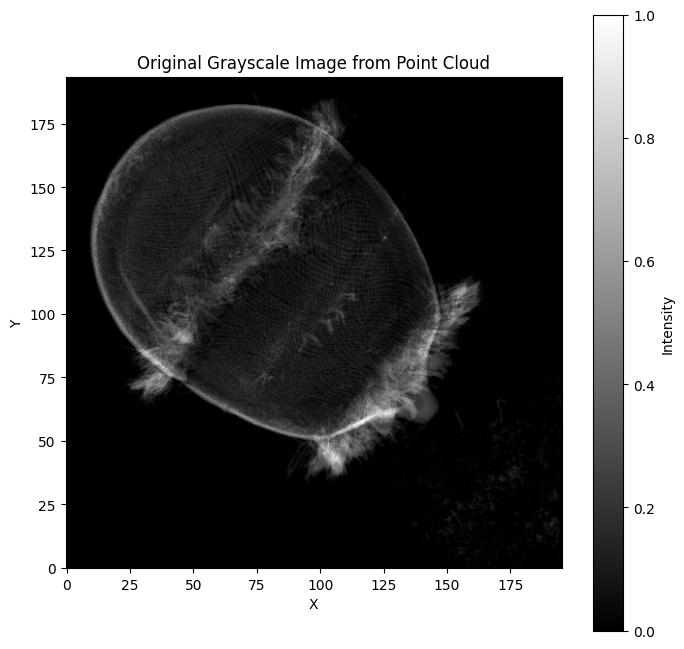

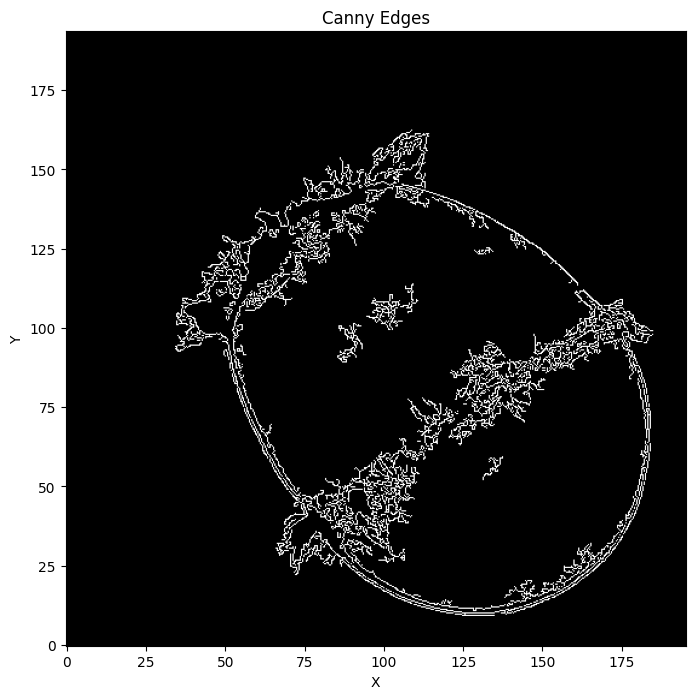

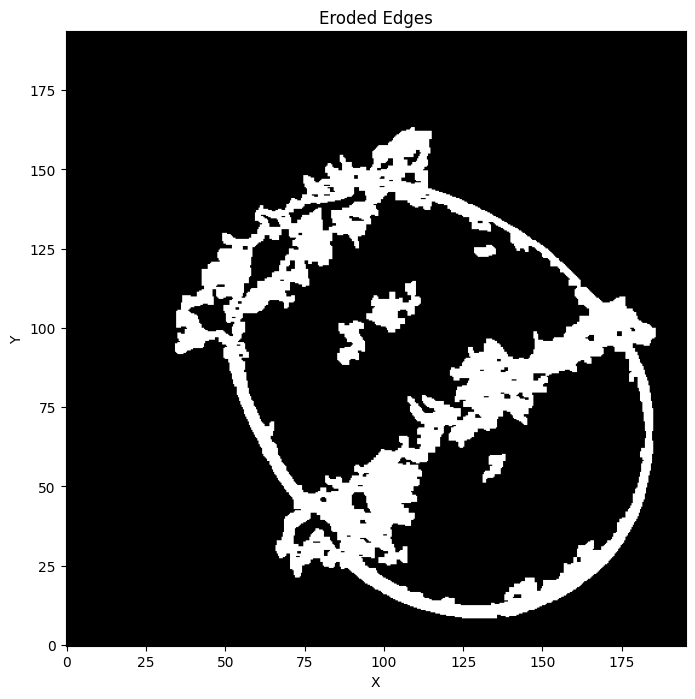

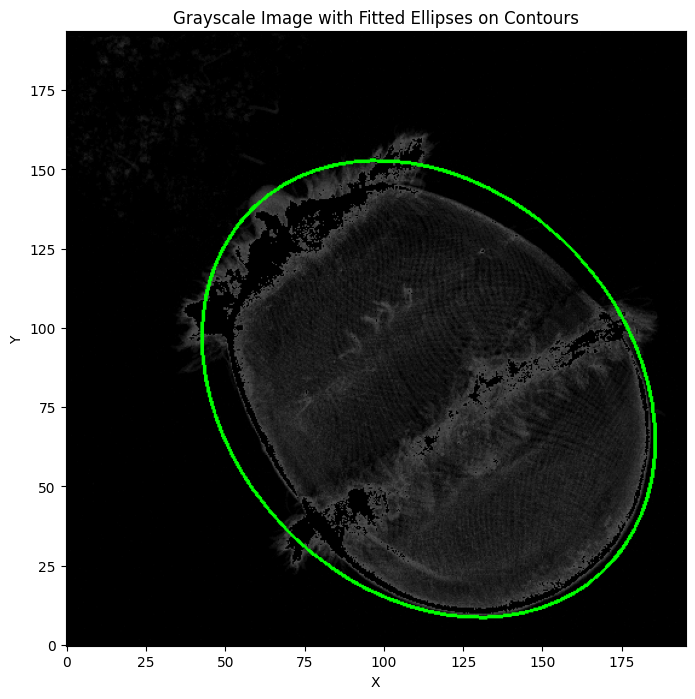

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-3.89221756e-01, -7.22500511e-03,  3.74771746e-01,  7.56768496e-01,
         1.13876525e+00,  1.52076200e+00,  1.90275875e+00,  2.28475550e+00,
         2.66675225e+00,  3.04874900e+00,  3.43074575e+00,  3.81274250e+00,
         4.19473925e+00,  4.57673600e+00,  4.95873275e+00,  5.34072951e+00,
         5.72272626e+00,  6.10472301e+00,  6.48671976e+00,  6.86871651e+00,
         7.25071326e+00,  7.63271001e+00,  8.01470676e+00,  8.39670351e+00,
         8.77870026e+00,  9.16069701e+00,  9.54269376e+00,  9.92469051e+00,
         1.03066873e+01,  1.06886840e+01,  1.10706808e+01,  1.14526775e+01,
         1.18346743e+01,  1.22166710e+01,  1.25986678e+01,  1.29806645e+01,
         1.33626613e+01,  1.37446580e+01,  1.41266548e+01,  1.45086

In [12]:
pointcloud_to_grayscale(projected_points_1[0, :], projected_points_1[1, :], projected_points_1[2, :])

In [13]:
########## Another trial version - because sometimes the flattened 2D image doesn't align perfectly with the 3D projection ############

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2
# from mayavi import mlab
# from sklearn.decomposition import PCA

# def compute_max_spread_point(point_cloud):
#     mean_point = np.mean(point_cloud, axis=1)
#     diffs = point_cloud - mean_point[:, np.newaxis]
#     dists = np.linalg.norm(diffs, axis=0)
#     max_spread_index = np.argmax(dists)
#     return point_cloud[:, max_spread_index]

# def project_point_onto_plane(point, normal, point_on_plane):
#     point_to_plane = point - point_on_plane
#     distance = np.dot(point_to_plane, normal)
#     projected_point = point - distance * normal
#     return projected_point

# def project_points_onto_plane(point_cloud, normal, point_on_plane):
#     projected_points = np.apply_along_axis(project_point_onto_plane, 1, point_cloud.T, normal, point_on_plane)
#     return projected_points.T

# def visualize_pointcloud_with_axis_and_plane(point_cloud, axis, mean, plane_point, title=None, fig_id=1):
#     x = point_cloud[0, :] 
#     y = point_cloud[1, :] 
#     z = point_cloud[2, :] 

#     if title is None:
#         title = "Point Cloud with Axis of Symmetry and Plane"

#     col = z
#     fig = mlab.figure(fig_id, bgcolor=(0, 0, 0), size=(800, 800))
#     mlab.points3d(x, y, z, col, mode="point", colormap='spectral', figure=fig)
    
#     mlab.plot3d([mean[0] - 50 * axis[0], mean[0] + 50 * axis[0]],
#                 [mean[1] - 50 * axis[1], mean[1] + 50 * axis[1]],
#                 [mean[2] - 50 * axis[2], mean[2] + 50 * axis[2]],
#                 tube_radius=1, color=(1, 1, 1))
    
#     normal = np.cross(axis, plane_point - mean)
#     normal /= np.linalg.norm(normal)
#     d = -np.dot(normal, mean)
#     xx, yy = np.meshgrid(np.linspace(mean[0] - 50, mean[0] + 50, 10), 
#                          np.linspace(mean[1] - 50, mean[1] + 50, 10))
#     zz = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]
    
#     mlab.mesh(xx, yy, zz, opacity=0.5, color=(0, 1, 0))
    
#     mlab.title(title, height=0.1, size=0.4)
#     mlab.show()

# def visualize_projected_points(projected_points, title=None, fig_id=2):
#     x = projected_points[0, :] 
#     y = projected_points[1, :] 
#     z = projected_points[2, :] 

#     if title is None:
#         title = "Projected Points on the Plane"

#     col = z
#     fig = mlab.figure(fig_id, bgcolor=(0, 0, 0), size=(800, 800))
#     mlab.points3d(x, y, z, col, mode="point", colormap='spectral', figure=fig)
    
#     mlab.title(title, height=0.1, size=0.4)
#     mlab.show()

# def find_balanced_plane(point_cloud, axis, mean_point):
#     def compute_plane_params(normal, point):
#         d = -np.dot(normal, point)
#         distances = np.dot(point_cloud.T, normal) + d
#         return np.abs(distances)

#     initial_plane_point = compute_max_spread_point(point_cloud)
#     initial_plane_normal = np.cross(axis, initial_plane_point - mean_point)
#     initial_plane_normal /= np.linalg.norm(initial_plane_normal)
    
#     best_plane_point = mean_point
#     min_deviation = np.inf
#     for i in range(10):
#         offset = (np.random.rand(3) - 0.5) * 10
#         trial_plane_point = mean_point + offset
#         normal = np.cross(axis, trial_plane_point - mean_point)
#         normal /= np.linalg.norm(normal)
#         distances = compute_plane_params(normal, trial_plane_point)
#         deviation = np.std(distances)
#         if deviation < min_deviation:
#             min_deviation = deviation
#             best_plane_point = trial_plane_point

#     best_plane_normal = np.cross(axis, best_plane_point - mean_point)
#     best_plane_normal /= np.linalg.norm(best_plane_normal)

#     return best_plane_point, best_plane_normal

# def compute_transformation_matrix(plane_normal):
#     # Compute the transformation matrix to align the plane with the XY plane
#     z_axis = plane_normal
#     z_axis /= np.linalg.norm(z_axis)
    
#     y_axis = np.array([0, 1, 0]) if np.abs(z_axis[1]) < 0.9 else np.array([1, 0, 0])
#     x_axis = np.cross(y_axis, z_axis)
#     x_axis /= np.linalg.norm(x_axis)
#     y_axis = np.cross(z_axis, x_axis)
    
#     rotation_matrix = np.vstack([x_axis, y_axis, z_axis]).T
    
#     return rotation_matrix

# def apply_transformation(points, rotation_matrix, translation_vector):
#     return np.dot(rotation_matrix, points - translation_vector[:, np.newaxis])

# def generate_2d_image_from_transformed_points(x, y, image_size=(512, 512), threshold_value=80):
#     x_norm = (x - np.min(x)) / (np.max(x) - np.min(x)) * (image_size[0] - 1)
#     y_norm = (y - np.min(y)) / (np.max(y) - np.min(y)) * (image_size[1] - 1)
    
#     image = np.zeros(image_size, dtype=np.float32)

#     for i in range(len(x)):
#         xi = int(x_norm[i])
#         yi = int(y_norm[i])
#         if 0 <= xi < image_size[0] and 0 <= yi < image_size[1]:
#             image[yi, xi] = max(image[yi, xi], 255)  # Set to max intensity

#     image = (image / np.max(image) * 255).astype(np.uint8)
#     _, image_thresh = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)

#     plt.figure(figsize=(8, 8))
#     plt.imshow(image_thresh, cmap='gray', origin='lower')
#     plt.title('2D Image Parallel to the Plane')
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.grid(False)
#     plt.show()

#     return image_thresh

# def main_workflow(point_cloud):
#     pca = PCA(n_components=3)
#     pca.fit(point_cloud.T)
#     refined_axis_of_symmetry = pca.components_[0]
#     mean_point = np.mean(point_cloud, axis=1)

#     balanced_plane_point, balanced_plane_normal = find_balanced_plane(point_cloud, refined_axis_of_symmetry, mean_point)
#     projected_points = project_points_onto_plane(point_cloud, balanced_plane_normal, balanced_plane_point)
    
#     visualize_pointcloud_with_axis_and_plane(point_cloud, refined_axis_of_symmetry, mean_point, balanced_plane_point)
#     visualize_projected_points(projected_points)

#     rotation_matrix = compute_transformation_matrix(balanced_plane_normal)
#     translation_vector = balanced_plane_point
    
#     transformed_points = apply_transformation(projected_points, rotation_matrix, translation_vector)
    
#     x = transformed_points[0, :]
#     y = transformed_points[1, :]
    
#     generate_2d_image_from_transformed_points(x, y)
    
# main_workflow(point_cloud_test_1)

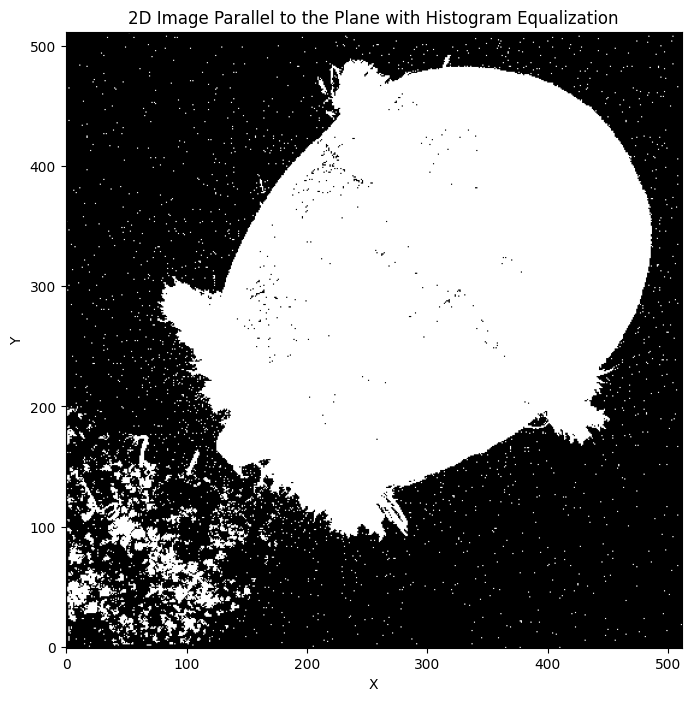

Major Axis Real Length: 196.08051339536132 Micrometers
Minor Axis Real Length: 112.46113568730468 Micrometers


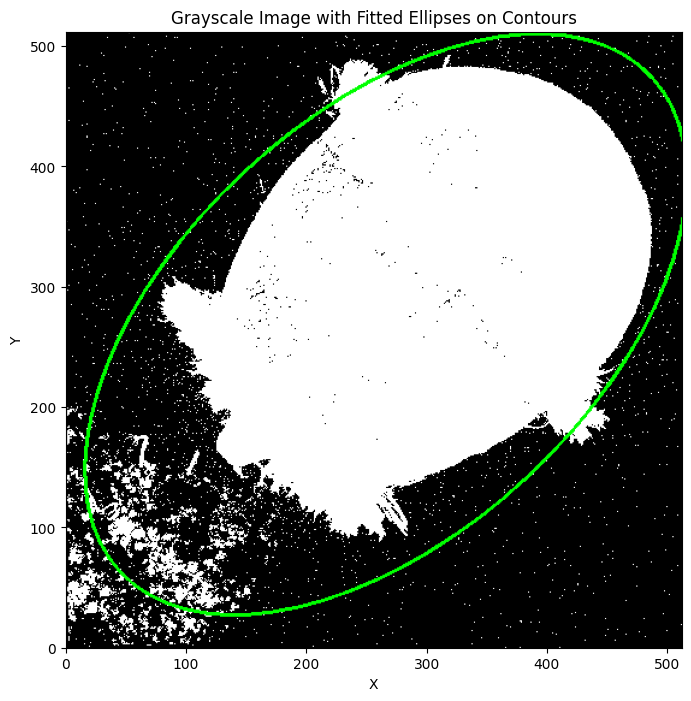

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mayavi import mlab
from sklearn.decomposition import PCA

# Compute the point with the maximum spread from the mean
def compute_max_spread_point(point_cloud):
    mean_point = np.mean(point_cloud, axis=1)
    diffs = point_cloud - mean_point[:, np.newaxis]
    dists = np.linalg.norm(diffs, axis=0)
    max_spread_index = np.argmax(dists)
    return point_cloud[:, max_spread_index]

# Project a point onto a plane
def project_point_onto_plane(point, normal, point_on_plane):
    point_to_plane = point - point_on_plane
    distance = np.dot(point_to_plane, normal)
    projected_point = point - distance * normal
    return projected_point

# Project all points onto a plane
def project_points_onto_plane(point_cloud, normal, point_on_plane):
    projected_points = np.apply_along_axis(project_point_onto_plane, 1, point_cloud.T, normal, point_on_plane)
    return projected_points.T

# Visualize the point cloud with axis and plane
def visualize_pointcloud_with_axis_and_plane(point_cloud, axis, mean, plane_point, title=None, fig_id=1):
    x = point_cloud[0, :] 
    y = point_cloud[1, :] 
    z = point_cloud[2, :] 

    if title is None:
        title = "Point Cloud with Axis of Symmetry and Plane"

    col = z
    fig = mlab.figure(fig_id, bgcolor=(0, 0, 0), size=(800, 800))
    mlab.points3d(x, y, z, col, mode="point", colormap='spectral', figure=fig)
    
    mlab.plot3d([mean[0] - 50 * axis[0], mean[0] + 50 * axis[0]],
                [mean[1] - 50 * axis[1], mean[1] + 50 * axis[1]],
                [mean[2] - 50 * axis[2], mean[2] + 50 * axis[2]],
                tube_radius=1, color=(1, 1, 1))
    
    normal = np.cross(axis, plane_point - mean)
    normal /= np.linalg.norm(normal)
    d = -np.dot(normal, mean)
    xx, yy = np.meshgrid(np.linspace(mean[0] - 50, mean[0] + 50, 10), 
                         np.linspace(mean[1] - 50, mean[1] + 50, 10))
    zz = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]
    
    mlab.mesh(xx, yy, zz, opacity=0.5, color=(0, 1, 0))
    
    mlab.title(title, height=0.1, size=0.4)
    mlab.show()

# Visualize the projected points
def visualize_projected_points(projected_points, title=None, fig_id=2):
    x = projected_points[0, :] 
    y = projected_points[1, :] 
    z = projected_points[2, :] 

    if title is None:
        title = "Projected Points on the Plane"

    col = z
    fig = mlab.figure(fig_id, bgcolor=(0, 0, 0), size=(800, 800))
    mlab.points3d(x, y, z, col, mode="point", colormap='spectral', figure=fig)
    
    mlab.title(title, height=0.1, size=0.4)
    mlab.show()

# Compute a transformation matrix to align the plane with the XY plane
def compute_transformation_matrix(plane_normal):
    z_axis = plane_normal
    z_axis /= np.linalg.norm(z_axis)
    
    y_axis = np.array([0, 1, 0]) if np.abs(z_axis[1]) < 0.9 else np.array([1, 0, 0])
    x_axis = np.cross(y_axis, z_axis)
    x_axis /= np.linalg.norm(x_axis)
    y_axis = np.cross(z_axis, x_axis)
    
    rotation_matrix = np.vstack([x_axis, y_axis, z_axis]).T
    return rotation_matrix

# Apply the transformation matrix to the points
def apply_transformation(points, rotation_matrix, translation_vector):
    return np.dot(rotation_matrix, points - translation_vector[:, np.newaxis])

# Generate a 2D image from the transformed points with histogram normalization
def generate_2d_image_from_transformed_points(x, y, image_size=(512, 512), threshold_value=80):
    x_norm = (x - np.min(x)) / (np.max(x) - np.min(x)) * (image_size[0] - 1)
    y_norm = (y - np.min(y)) / (np.max(y) - np.min(y)) * (image_size[1] - 1)
    
    image = np.zeros(image_size, dtype=np.float32)

    for i in range(len(x)):
        xi = int(x_norm[i])
        yi = int(y_norm[i])
        if 0 <= xi < image_size[0] and 0 <= yi < image_size[1]:
            image[yi, xi] = max(image[yi, xi], 255)  # Set to max intensity

    image = (image / np.max(image) * 255).astype(np.uint8)
    
    # Histogram normalization
    image_eq = cv2.equalizeHist(image)

    _, image_thresh = cv2.threshold(image_eq, threshold_value, 255, cv2.THRESH_BINARY)

    plt.figure(figsize=(8, 8))
    plt.imshow(image_thresh, cmap='gray', origin='lower')
    plt.title('2D Image Parallel to the Plane with Histogram Equalization')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(False)
    plt.show()

    return image_thresh

# Convert the 2D image to grayscale, apply morphological operations, and detect ellipses
def pointcloud_to_grayscale_and_detect_ellipses(image_thresh, image_size=(512, 512), min_contour_area=2000, min_major_axis=50, threshold_value=80, x_scale=3249932e-7, y_scale=3249932e-7):
    def compute_real_length(major_axis_length, minor_axis_length, x_scale, y_scale):
        major_axis_real_length = major_axis_length * x_scale
        minor_axis_real_length = minor_axis_length * y_scale
        return major_axis_real_length, minor_axis_real_length

    # Pre-processing of the image for the contours detection
    edges_canny = cv2.Canny(image_thresh, 50, 250)  # Adjust Canny thresholds
    edges_dilated = cv2.dilate(edges_canny, None, iterations=2)    
    kernel = np.ones((1, 2), np.uint8)
    edges_eroded = cv2.erode(edges_dilated, kernel, iterations=2)
    contours_canny, _ = cv2.findContours(edges_eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    ellipse_image = cv2.cvtColor(image_thresh, cv2.COLOR_GRAY2BGR)
    
    # Fitting the ellipses based on the detected contours 
    for contour in contours_canny:
        area = cv2.contourArea(contour)
        if area >= min_contour_area and len(contour) >= 5:
            ellipse = cv2.fitEllipse(contour)
            (center, axes, angle) = ellipse
            major_axis = max(axes)
            if major_axis >= min_major_axis:
                cv2.ellipse(ellipse_image, ellipse, (0, 255, 0), 2)  # Draw the ellipse
                
                # Extract dimensions of major and minor axes
                major_axis_length = axes[1]
                minor_axis_length = axes[0]
                
                # Convert axis lengths from pixels to real-world units
                major_axis_real_length, minor_axis_real_length = compute_real_length(major_axis_length, minor_axis_length, x_scale, y_scale)
                print(f"Major Axis Real Length: {major_axis_real_length:} Micrometers")
                print(f"Minor Axis Real Length: {minor_axis_real_length:} Micrometers")

    # Plot the image with ellipses fitted on contours
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(ellipse_image, cv2.COLOR_BGR2RGB), origin='lower', extent=[0, image_size[0], 0, image_size[1]])
    plt.title('Grayscale Image with Fitted Ellipses on Contours')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(False)
    plt.show()

    return ellipse_image

# Find a balanced plane
def find_balanced_plane(point_cloud, axis, mean_point):
    def compute_plane_params(normal, point):
        d = -np.dot(normal, point)
        distances = np.dot(point_cloud.T, normal) + d
        return np.abs(distances)

    initial_plane_point = compute_max_spread_point(point_cloud)
    initial_plane_normal = np.cross(axis, initial_plane_point - mean_point)
    initial_plane_normal /= np.linalg.norm(initial_plane_normal)
    
    best_plane_point = mean_point
    min_deviation = np.inf
    for i in range(10):
        offset = (np.random.rand(3) - 0.5) * 10
        trial_plane_point = mean_point + offset
        normal = np.cross(axis, trial_plane_point - mean_point)
        normal /= np.linalg.norm(normal)
        distances = compute_plane_params(normal, trial_plane_point)
        deviation = np.std(distances)
        if deviation < min_deviation:
            min_deviation = deviation
            best_plane_point = trial_plane_point

    best_plane_normal = np.cross(axis, best_plane_point - mean_point)
    best_plane_normal /= np.linalg.norm(best_plane_normal)

    return best_plane_point, best_plane_normal

# Main workflow
def main_workflow(point_cloud):
    pca = PCA(n_components=3)
    pca.fit(point_cloud.T)
    refined_axis_of_symmetry = pca.components_[0]
    mean_point = np.mean(point_cloud, axis=1)

    balanced_plane_point, balanced_plane_normal = find_balanced_plane(point_cloud, refined_axis_of_symmetry, mean_point)
    projected_points = project_points_onto_plane(point_cloud, balanced_plane_normal, balanced_plane_point)
    
    visualize_pointcloud_with_axis_and_plane(point_cloud, refined_axis_of_symmetry, mean_point, balanced_plane_point)
    visualize_projected_points(projected_points)

    rotation_matrix = compute_transformation_matrix(balanced_plane_normal)
    translation_vector = balanced_plane_point
    
    transformed_points = apply_transformation(projected_points, rotation_matrix, translation_vector)
    
    x = transformed_points[0, :]
    y = transformed_points[1, :]
    
    # Generate 2D image and perform ellipse detection
    image_thresh = generate_2d_image_from_transformed_points(x, y)
    pointcloud_to_grayscale_and_detect_ellipses(image_thresh, image_size=image_thresh.shape)

main_workflow(point_cloud_test_1)